In [29]:
import pandas as pd
import numpy as np
from ggplot import *
% matplotlib inline

# Define Mortgage Details: 

Function for calculating monthly payment:

In [30]:
# Calculates monthly payment given number of months(n), loan amount(L), and the monthly interest rate (APY/12)
def calculate_montly_payment(n,L,monthly_interest):
    I = monthly_interest
    numerator = L*(1 + I)**n
    denomenator = -1*(1 - (1 + I)**n) / I
    return (numerator/denomenator)

Estimate details:

In [31]:
# Enter Best Estimates Here
time = 15 # number of years for mortgage
interest = .03 # APY interest rate
price = 320000 # dollars
down_payment = .2 # percent/100
marginal_tax_rate = .25 
expected_deduction = 6400 # expected standard deduction for current year
expected_deduction_yearly_increase = 100 # expected increase in standard deduction each year
property_tax = .01 # percent of house value payed as yearly property tax
yearly_house_appreciation = .01 # percent appreciation of house value
yearly_maintenance = .003 # percent of house value set aside yearly for repairs and maintenance
hoa_fee = 300 # montly hoa fee
hoa_yearly_increase = .01 # yearly percent increase in hoa fee
homeowner_insurance = 67 
homeowner_yearly_increase = .01 # yearly percent increase in insurance
monthly_rent = 1850 # expected monthly rent for current year
rent_yearly_increase = .01 # yearly percent increase in rent
percent_vacancy = 1.0/12.0 # percent of the year with vacancy
rent_percent = 0.6 #percent of monthly rent as income
closing_buy = .05 # percent of house value for closing cost when buying
closing_sell = .05 # percent of house value for closing cost when selling



Calculate monthly payment:

In [32]:
# For calculations: do not edit
n = time * 12 #number of months for the loan
L = price * (1.0 - down_payment) # loan amount
monthly_interest = interest/12.0 # monthly interest rate as a percent/100
p = calculate_montly_payment(n,L,monthly_interest) # monthly payment
print 'Monthly Payment = %.2f'%p

Monthly Payment = 1767.89


Estimates for opportunity cost:

In [33]:
# For opportunity costs
long_term_capital_gains = .15
investment_return = .07
opportunity_rent = 850

# Calculate Cumulative Equity and Interest per month: 

In [34]:
mortgage = pd.DataFrame()
loan = L
month_list = range(1,n+1)
for month in month_list:
    mortgage_month = pd.DataFrame()
    mortgage_month['Month'] = [month]
    mortgage_month['Loan_Before_Payment'] = loan
    loan = loan * (1+ monthly_interest) - p
    mortgage_month['Loan_After_Payment'] = loan
    mortgage_month['Equity_Gain'] = mortgage_month['Loan_Before_Payment'] - mortgage_month['Loan_After_Payment']
    mortgage = pd.concat([mortgage,mortgage_month])
mortgage['Interest_Paid'] = p - mortgage['Equity_Gain']
#mortgage['Tax_Savings'] = np.round(mortgage['Interest_Paid'] * marginal_tax_rate)
#mortgage['Effective_Interest_Paid'] = np.round(mortgage['Interest_Paid'] * (1-marginal_tax_rate))
mortgage['Year'] = np.ceil(mortgage['Month']/12.0)
mortgage['Expected_Tax_Return'] = (expected_deduction/12.0 + expected_deduction_yearly_increase * mortgage['Year']/12.0) * (marginal_tax_rate)
mortgage['Effective_Interest_Paid'] = mortgage['Interest_Paid'] * (1-marginal_tax_rate) + mortgage['Expected_Tax_Return']
mortgage['Effective_Interest_Paid'] = mortgage[['Interest_Paid','Effective_Interest_Paid']].min(axis = 1)
mortgage['Cumulative_Equity_Gain'] = mortgage['Equity_Gain'].cumsum()
#mortgage['Cumulative_Interest_Paid'] = mortgage['Interest_Paid'].cumsum()
mortgage['Cumulative_Effective_Interest_Paid'] = mortgage['Effective_Interest_Paid'].cumsum()
#mortgage['Total_Equity_With_Appreciation'] = np.round(mortgage['Cumulative_Equity_Gain'] * (1 + yearly_house_appreciation)**mortgage['Year'])
mortgage['Total_Equity_With_Appreciation'] = (mortgage['Cumulative_Equity_Gain'] + down_payment * price) * (1 + yearly_house_appreciation)**mortgage['Year']
mortgage.set_index([range(len(mortgage))], inplace = True)
#mortgage.head(200)

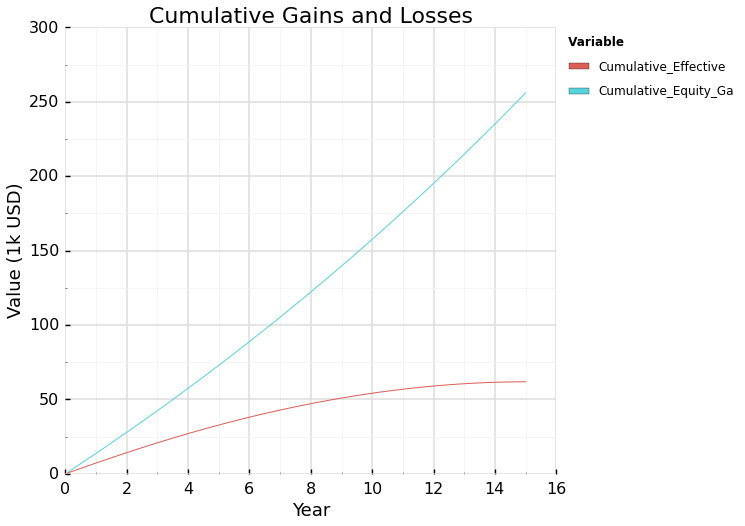

<ggplot: (33104742)>

In [35]:
plot_data = pd.melt(mortgage[['Month','Cumulative_Equity_Gain','Cumulative_Effective_Interest_Paid']], id_vars = ['Month'], value_vars = ['Cumulative_Equity_Gain','Cumulative_Effective_Interest_Paid'])
ggplot(aes(x = 'Month/12.0', y = 'value/1000', color = 'variable'), data = plot_data)\
+ geom_line()\
+ theme_seaborn(context = 'poster')\
+ xlab('Year')\
+ ylab('Value (1k USD)')\
+ ggtitle('Cumulative Gains and Losses')
 

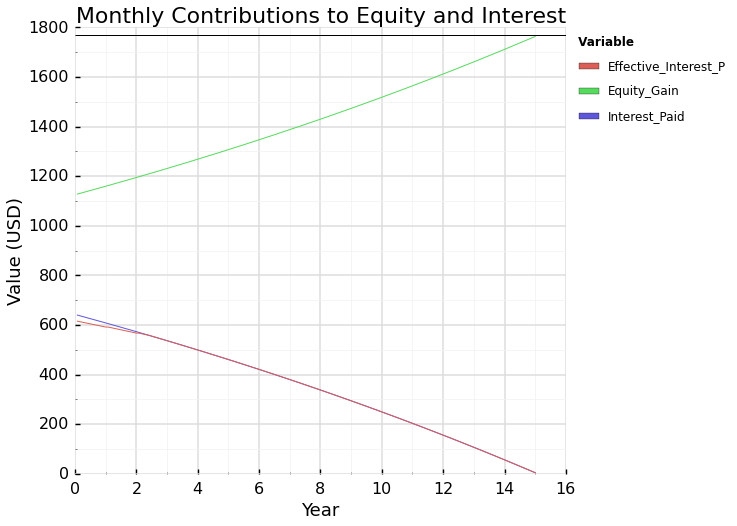

<ggplot: (34887379)>

In [36]:
plot_data_monthly = pd.melt(mortgage[['Month','Equity_Gain','Effective_Interest_Paid','Interest_Paid']], id_vars = ['Month'], value_vars = ['Equity_Gain','Effective_Interest_Paid','Interest_Paid'])
ggplot(aes(x = 'Month/12.0', y = 'value', color = 'variable'), data = plot_data_monthly)\
+ geom_line()\
+ geom_hline(yintercept = [np.round(p)], color = 'black')\
+ theme_seaborn(context = 'poster')\
+ xlab('Year')\
+ ylab('Value (USD)')\
+ ggtitle('Monthly Contributions to Equity and Interest')
 

# Yearly Info

In [37]:
yearly_mortgage = mortgage[mortgage.Month%12 == 0]
yearly_mortgage = yearly_mortgage[['Year','Cumulative_Effective_Interest_Paid','Total_Equity_With_Appreciation']]
#yearly_mortgage['Total_Equity_With_Appreciation'] = np.round(yearly_mortgage['Total_Equity_With_Appreciation'] + (down_payment * price) * (1 + yearly_house_appreciation)**yearly_mortgage['Year'])
yearly_mortgage['House_Value'] = price * (1 + yearly_house_appreciation)**yearly_mortgage['Year']

#costs
yearly_mortgage['Effective_Property_Tax'] = property_tax * yearly_mortgage['House_Value'] #* (1 - marginal_tax_rate)
yearly_mortgage['Cumulative_Effective_Property_Tax'] = yearly_mortgage['Effective_Property_Tax'].cumsum()
yearly_mortgage['HOA'] = 12 * hoa_fee * ((1 + hoa_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_HOA'] = yearly_mortgage['HOA'].cumsum()
yearly_mortgage['Homeowner_Insurance'] = 12 *homeowner_insurance * ((1 + homeowner_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_Homeowner_Insurance'] = yearly_mortgage['Homeowner_Insurance'].cumsum()
yearly_mortgage['Maintenance'] = yearly_maintenance * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Maintenance'] = yearly_mortgage['Maintenance'].cumsum()
yearly_mortgage['Capital_Gains'] = (yearly_mortgage['House_Value'] - price) * long_term_capital_gains
yearly_mortgage['Total_Cost'] = yearly_mortgage['Cumulative_Effective_Property_Tax'] \
+ yearly_mortgage['Cumulative_Effective_Interest_Paid']\
+ yearly_mortgage['Cumulative_HOA']\
+ yearly_mortgage['Cumulative_Homeowner_Insurance']\
+ yearly_mortgage['Cumulative_Maintenance']\
+ price * closing_buy\
+ yearly_mortgage['House_Value'] * closing_sell\
+ yearly_mortgage['Capital_Gains']

#rental income
yearly_mortgage['Rent_Income'] = ((1-marginal_tax_rate) * (1 - percent_vacancy) * 12 * monthly_rent * rent_percent ) * ((1 + rent_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Total_Rent_Income'] = yearly_mortgage['Rent_Income'].cumsum()
#yearly_mortgage['Effective_Cost'] = yearly_mortgage['Total_Cost'] - yearly_mortgage['Total_Rent_Income']

#Net Gain
yearly_mortgage['Net_Gain'] = yearly_mortgage['Total_Equity_With_Appreciation'] + yearly_mortgage['Total_Rent_Income'] - yearly_mortgage['Total_Cost']
yearly_mortgage['Effective_Cost'] = yearly_mortgage['Total_Cost'] - yearly_mortgage['Total_Rent_Income']
#yearly_mortgage.head(30)

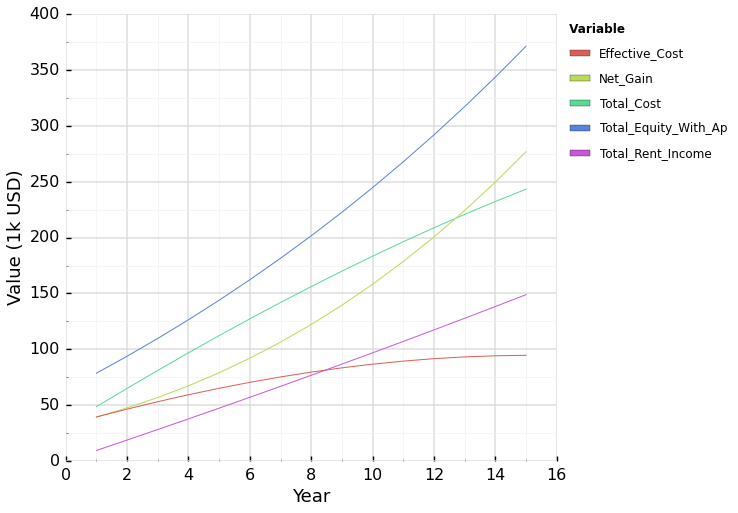

<ggplot: (34889374)>

In [38]:
total_plot = pd.melt(yearly_mortgage[['Year','Total_Equity_With_Appreciation','Total_Cost','Total_Rent_Income','Net_Gain','Effective_Cost']], id_vars = ['Year'], value_vars = ['Effective_Cost','Total_Equity_With_Appreciation','Total_Cost','Total_Rent_Income','Net_Gain'])
total_plot.set_index([range(len(total_plot))], inplace = True)
total_plot['value'] = np.round(total_plot['value'])
ggplot(aes(x = 'Year', y = 'value/1000', color = 'variable'), data = total_plot)\
+ geom_line()\
+ theme_seaborn(context = 'poster')\
+ ylab('Value (1k USD)')
#+ xlim(0,10)
 

# Opportunity Cost: 

In [39]:
#Opporunity_Cost
yearly_opportunity = pd.DataFrame()
yearly_opportunity['Year'] = yearly_mortgage['Year']
yearly_opportunity['Yearly_Rent_Cost'] = 12 * opportunity_rent * ((1 + rent_yearly_increase) ** yearly_mortgage['Year'])
yearly_opportunity = pd.merge(yearly_opportunity,yearly_mortgage[['Year','Cumulative_Effective_Interest_Paid','Effective_Property_Tax','HOA','Homeowner_Insurance','Net_Gain','Rent_Income']], how = 'inner', on = 'Year')
yearly_opportunity['Interest'] = yearly_opportunity['Cumulative_Effective_Interest_Paid']
yearly_opportunity['Interest'].iloc[1:len(yearly_opportunity)] = np.diff(yearly_opportunity['Cumulative_Effective_Interest_Paid'])
yearly_opportunity['Initial_Opportunity'] = ((down_payment+closing_buy)*price) * (1 + investment_return)**(yearly_opportunity['Year']) * (1-long_term_capital_gains)
yearly_opportunity['Recurring_Costs'] = yearly_opportunity['Effective_Property_Tax']\
+ yearly_opportunity['HOA']\
+ yearly_opportunity['Homeowner_Insurance']\
+ yearly_opportunity['Interest']\
- yearly_opportunity['Rent_Income']
#yearly_mortgage['Yearly_Rent_Cost'] = 12 * opportunity_rent * ((1 + rent_yearly_increase) ** yearly_mortgage['Year'])
#yearly_mortgage['Total_Rent_Cost'] = yearly_mortgage['Yearly_Rent_Cost'].cumsum()

In [40]:
yearly_opportunity

,Year,Yearly_Rent_Cost,Cumulative_Effective_Interest_Paid,Effective_Property_Tax,HOA,Homeowner_Insurance,Net_Gain,Rent_Income,Interest,Initial_Opportunity,Recurring_Costs
0,1,10302.000000,7244.254032,3232.000000,3636.000000,812.040000,39214.733541,9249.075000,7244.254032,72760.000000,5675.219032
1,2,10405.020000,14200.474732,3264.320000,3672.360000,820.160400,47426.452885,9341.565750,6956.220700,77853.200000,5371.495350
2,3,10509.070200,20837.849648,3296.963200,3709.083600,828.362004,56696.040918,9434.981408,6637.374916,83302.924000,5036.802313
3,4,10614.160902,27039.584067,3329.932832,3746.174436,836.645624,67171.599281,9529.331222,6201.734419,89134.128680,4585.156089
4,5,10720.302511,32784.685745,3363.232160,3783.636180,845.012080,78906.714101,9624.624534,5745.101678,95373.517688,4112.357565
5,6,10827.505536,38059.265760,3396.864482,3821.472542,853.462201,91949.207670,9720.870779,5274.580016,102049.663926,3625.508462
6,7,10935.780591,42849.012747,3430.833127,3859.687268,861.996823,106348.718880,9818.079487,4789.746987,109193.140401,3124.184717
7,8,11045.138397,47139.180044,3465.141458,3898.284140,870.616791,122156.772964,9916.260282,4290.167297,116836.660229,2607.949405
8,9,11155.589781,50914.572457,3499.792873,3937.266982,879.322959,139426.853944,10015.422885,3775.392413,125015.226445,2076.352342
9,10,11267.145679,54159.532616,3534.790801,3976.639651,888.116189,158214.479907,10115.577113,3244.960159,133766.292296,1528.929687


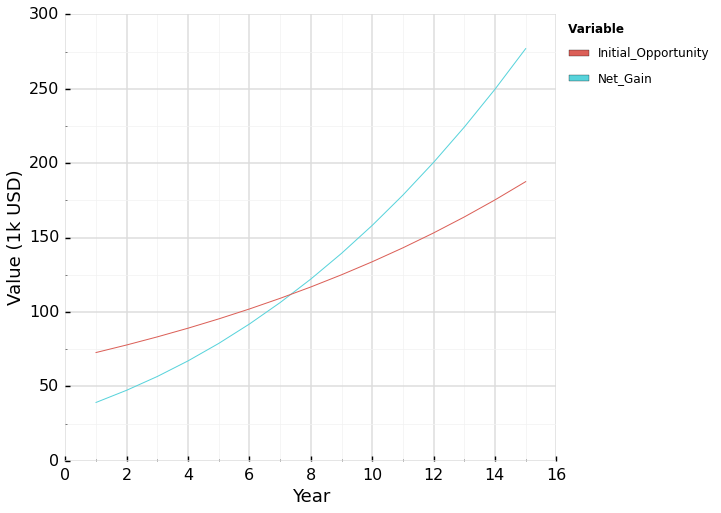

<ggplot: (32814901)>

In [41]:
opportunity_plot = pd.melt(yearly_opportunity[['Year','Net_Gain','Initial_Opportunity']], id_vars = ['Year'], value_vars = ['Net_Gain','Initial_Opportunity'])
opportunity_plot['value'] = np.round(opportunity_plot['value'])
ggplot(aes(x = 'Year', y = 'value/1000', color = 'variable'), data = opportunity_plot)\
+ geom_line()\
+ theme_seaborn(context = 'poster')\
+ ylab('Value (1k USD)')